In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os

In [27]:
import torchvision.models as models


In [15]:


print("CUDA available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected")

CUDA available: True
Using device: cuda
GPU name: Tesla P100-PCIE-16GB


In [18]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
transform_train = transforms.Compose([
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Randomly rotate some images by 20 degrees
    transforms.RandomRotation(20),
    # Randomly adjust color jitter of the images
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    # Randomly adjust sharpness
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() ,
    #randomly erase a pixel
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_set = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='.', train=False , download=True, transform=transform_test)

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 800

train_loader = DataLoader(dataset=train_set,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_loader = DataLoader(dataset=test_set,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)



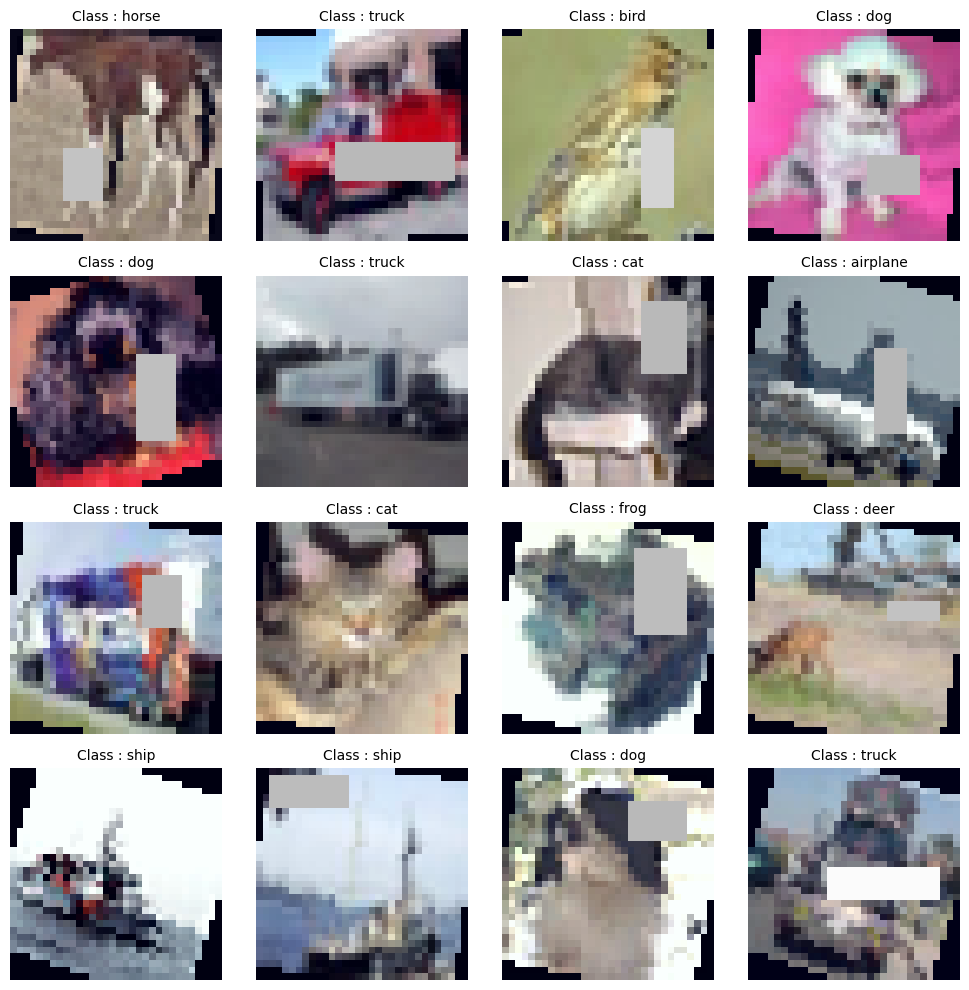

In [19]:
rand_idx = random.sample(range(len(train_set)), k=16)

plt.figure(figsize=(10,10))

for i, idx in enumerate(rand_idx):
    img, label = train_set[idx]

    # scale to [0,1] for display
    img = (img - img.min()) / (img.max() - img.min())

    img_class = train_set.classes[label]

    plt.subplot(4,4,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Class : {img_class}", fontsize=10)
    plt.axis(False)

plt.tight_layout()
plt.show()   

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256*8*8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)
    def forward(self, X):
        X = torch.relu(self.bn1(self.conv1(X)))
        X = torch.relu(self.bn2(self.conv2(X)))
        X = self.pool(X)

        X = torch.relu(self.bn3(self.conv3(X)))
        X = torch.relu(self.bn4(self.conv4(X)))
        X = self.pool(X)

        X = X.view(-1, 256*8*8)
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.output(X)
        return X

In [21]:
model= CNN().to(device)

In [28]:
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,          # start here, adjust later
    momentum=0.9,     # helps accelerate in relevant directions
    weight_decay=15e-5 # L2 regularization
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=70, eta_min=1e-5)

In [25]:
for epoch in range(70):
   
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct_test / total_test


    scheduler.step()

    print(f"Epoch [{epoch+1}/70] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Epoch [1/70] Train Loss: 1.3541 | Train Acc: 50.71% Test Loss: 1.1808 | Test Acc: 57.94%
Epoch [2/70] Train Loss: 1.2050 | Train Acc: 56.57% Test Loss: 1.0626 | Test Acc: 62.73%
Epoch [3/70] Train Loss: 1.0827 | Train Acc: 61.12% Test Loss: 0.9256 | Test Acc: 67.44%
Epoch [4/70] Train Loss: 1.0052 | Train Acc: 64.00% Test Loss: 0.9361 | Test Acc: 67.28%
Epoch [5/70] Train Loss: 0.9668 | Train Acc: 65.76% Test Loss: 0.8297 | Test Acc: 70.91%
Epoch [6/70] Train Loss: 0.9027 | Train Acc: 68.19% Test Loss: 0.8032 | Test Acc: 72.43%
Epoch [7/70] Train Loss: 0.8572 | Train Acc: 69.77% Test Loss: 0.8489 | Test Acc: 69.59%
Epoch [8/70] Train Loss: 0.8302 | Train Acc: 70.79% Test Loss: 0.7906 | Test Acc: 72.27%
Epoch [9/70] Train Loss: 0.7971 | Train Acc: 72.10% Test Loss: 0.8720 | Test Acc: 70.19%
Epoch [10/70] Train Loss: 0.7767 | Train Acc: 72.57% Test Loss: 0.6933 | Test Acc: 75.65%
Epoch [11/70] Train Loss: 0.7406 | Train Acc: 73.75% Test Loss: 0.6889 | Test Acc: 75.84%
Epoch [12/70] Train

In [31]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct_test / total_test


    

    print(f"Epoch [{epoch+1}/70] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Epoch [150/70] Train Loss: 0.6440 | Train Acc: 96.80% Test Loss: 0.8475 | Test Acc: 86.67%
